<h1> NBA Salary Project </h1>

Author: Oliver Jan

Purpose: The goal of this project is to determine, using machine learning, if an NBA player is really playing up to their salary. This is meant to be a fun, exploratory project for me to practice data science in a "real-world" business setting
The code was written primarily in python, and helper functions used are located in <i>helper_functions.py</i>.

Using my scraper utility in <i>basketball_data.py</i>, I can assimilate the data necessary for my analysis using <i>pandas</i>, an incredible open-source package for nifty data structuring for data analysis.

Data sources provided courtesy of basketball-reference.com and via BeautifulSoup4 for scraping web pages.

In [1]:
# import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import *
import sklearn

<h1>Data Munging and Data Merging</h1>

My scraper generated a file called <b>pergame_stats.csv</b> that has 2019-2020 season statistics for all NBA players. The problem with this particular table was that the table contained duplicated player rows that only occurred if a player was traded during the season. For instance, if a player was traded twice, that player would have three corresponding rows: a row with a team name of "TOT" to represent total statistics and individual rows for the two teams that the player played for. Instead of viewing this as a hindrance, I decided to engineer a feature called trades and include that in my dataset. 

I also went ahead and got salary information in a separate CSV file called <b>nba_salary.csv</b>. I did a left join to add salary information to all applicable NBA players.

In [2]:
# read data generated from basketball_data.py
pergame_stats_df = pd.read_csv('pergame_stats.csv', skipinitialspace=True)

# FEATURE ENGINEERING: Calculating number of times a player has been traded based on their frequency in the raw data
# Thoought it might be nifty to include the number of times a player has been traded
traded_df = pergame_stats_df.groupby(['Player'])
traded_df = pd.DataFrame(traded_df.size().reset_index(name='trades'))

# pergame_stats_df['Player'] = pergame_stats_df['Player'].apply(clean_jr)
pergame_stats_df = pergame_stats_df.drop_duplicates(subset='Player')

traded_df['trades'] = traded_df['trades'] - 1

df_with_trades = pergame_stats_df.merge(traded_df, on='Player')
df_with_trades = df_with_trades.set_index('Player')

# Looking at Salary Data

salary_df = pd.read_csv('nba_salary.csv', header=1)

# Need to use regex to clean up player name, have to chop off the ...\akljsdlkad01

name = salary_df['Player'][0]
salary_df['Player'] = salary_df['Player'].apply(clean_name)
salary_df['Player'] = salary_df['Player'].apply(clean_jr)
salary_df.columns
salary_df.rename(columns = {'2019-20▼':'2019_Salary'}, inplace=True)
salary_columns = ['Player', '2019_Salary']
salary_df = salary_df[salary_columns]
salary_df = salary_df.set_index('Player')

salary_trade_df = df_with_trades.merge(salary_df, how='left', left_on='Player', right_on='Player')
salary_trade_df = salary_trade_df.dropna()

# the only downside is that I dropped data corresponding to players that have yet to register a %..but I guess that won't really matter as they do not really play anyways

In [3]:
# tackling the multiple instances in the salary_trade_df
# first, going to convert salary information to int32

salary_trade_df['2019_Salary'] = salary_trade_df['2019_Salary'].apply(clean_currency)

In [4]:
salary_trade_df['2019_Salary'] = salary_trade_df['2019_Salary'].astype('float')

In [5]:
# removing duplicated data that appears
salary_trade_df = salary_trade_df.loc[~salary_trade_df.index.duplicated(keep='first')]

<h1>Exploratory Data Analysis</h1>

In [6]:
# correlation matrix to dataset, see if there's any issues with duplicates.

print(salary_trade_df.corr()[['2019_Salary']])
print(salary_trade_df['TOV'].max())

2019_Salary
Age             0.390406
G               0.208173
GS              0.488281
MP              0.574917
FG              0.628610
FGA             0.633623
FG%             0.113213
3P              0.426080
3PA             0.452123
3P%             0.154216
2P              0.571099
2PA             0.585211
2P%             0.065752
eFG%            0.121635
FT              0.607965
FTA             0.593104
FT%             0.135596
ORB             0.285287
DRB             0.549070
TRB             0.503379
AST             0.556041
STL             0.438423
BLK             0.295165
TOV             0.595773
PF              0.363729
PTS             0.642795
trades         -0.002730
2019_Salary     1.000000
4.8


In [7]:
# Features of interest from dataset with a correlation coefficient of greater than 0.55

print(salary_trade_df.corr()['2019_Salary'] > 0.55)

Age            False
G              False
GS             False
MP              True
FG              True
FGA             True
FG%            False
3P             False
3PA            False
3P%            False
2P              True
2PA             True
2P%            False
eFG%           False
FT              True
FTA             True
FT%            False
ORB            False
DRB            False
TRB            False
AST             True
STL            False
BLK            False
TOV             True
PF             False
PTS             True
trades         False
2019_Salary     True
Name: 2019_Salary, dtype: bool


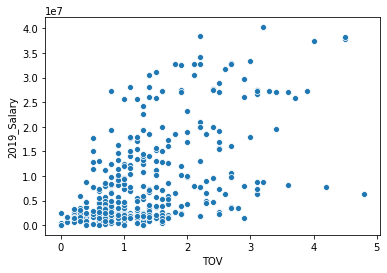

In [8]:
sns.scatterplot(x="TOV", y="2019_Salary", data=salary_trade_df) 

# data is interesting, since "high-usage players (players with a lot of minutes)" tend to turn the ball over more)

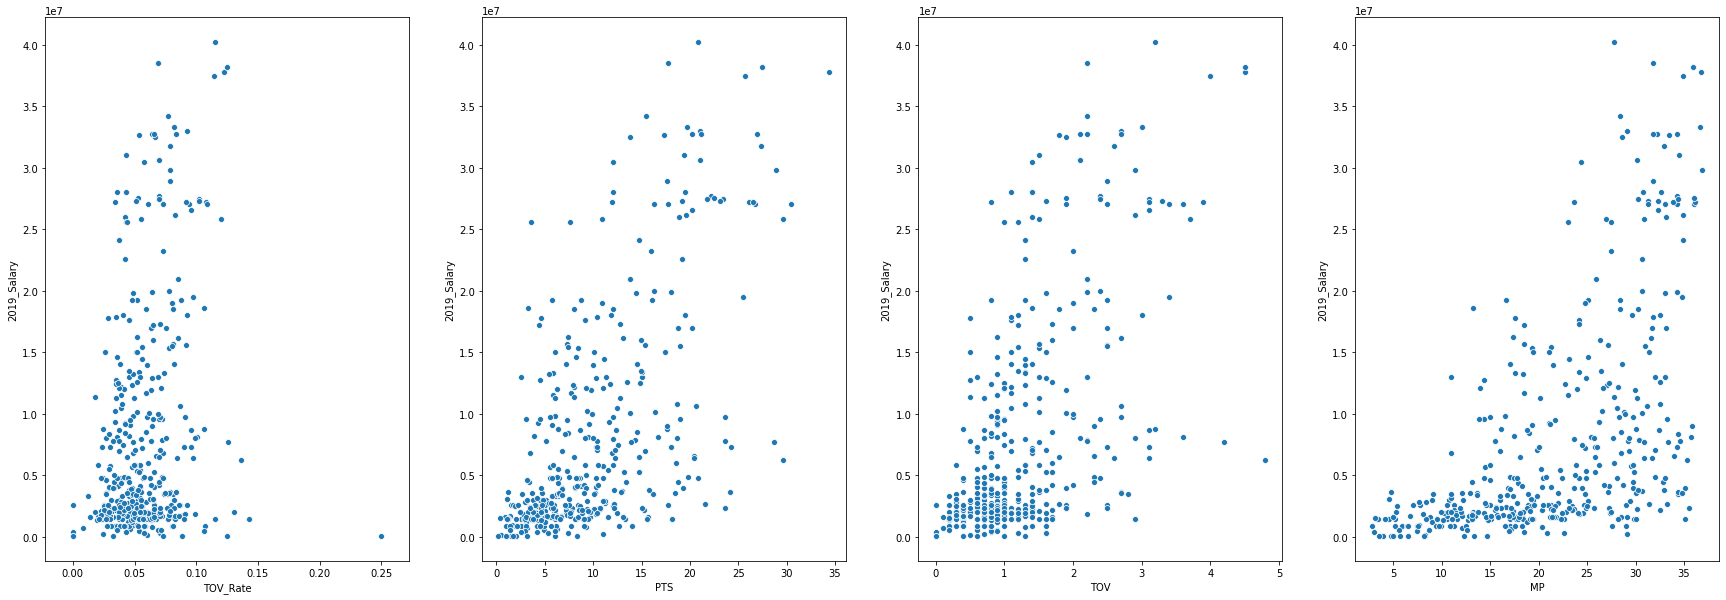

In [9]:
# playing around with subplots

salary_trade_df['TOV_Rate'] = salary_trade_df['TOV']/salary_trade_df['MP']

figs, axs = plt.subplots(ncols=4, figsize=(30,10))
sns.scatterplot(x="TOV_Rate", y="2019_Salary", data=salary_trade_df, ax=axs[0])
sns.scatterplot(x="PTS", y="2019_Salary", data=salary_trade_df, ax=axs[1])
sns.scatterplot(x="TOV", y="2019_Salary", data=salary_trade_df, ax=axs[2])
sns.scatterplot(x="MP", y="2019_Salary", data=salary_trade_df, ax=axs[3])
#sns.distplot(salary_trade_df['TOV_Rate'], bins=20, kde=False, ax=axs[3])
#sns.distplot(salary_trade_df['2019-20'], bins=20, kde=False, ax=axs[4])


In [10]:
# Explore more unique visualizations from the merged dataset
salary_trade_df.corr()['MP']

Age            0.140309
G              0.584276
GS             0.787425
MP             1.000000
FG             0.864069
FGA            0.876962
FG%            0.216969
3P             0.665282
3PA            0.676203
3P%            0.334346
2P             0.747008
2PA            0.776733
2P%            0.151502
eFG%           0.293417
FT             0.689405
FTA            0.687584
FT%            0.199062
ORB            0.364199
DRB            0.703491
TRB            0.643949
AST            0.694011
STL            0.709423
BLK            0.330365
TOV            0.775297
PF             0.712411
PTS            0.862292
trades        -0.127736
2019_Salary    0.574917
TOV_Rate       0.200069
Name: MP, dtype: float64

In [11]:
# descriptive statistics summary
salary_trade_df['2019_Salary'].describe()

count    4.170000e+02
mean     7.923097e+06
std      8.991039e+06
min      5.075200e+04
25%      1.737145e+06
50%      3.635760e+06
75%      1.081000e+07
max      4.023176e+07
Name: 2019_Salary, dtype: float64

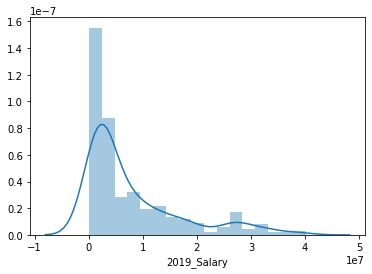

In [12]:
# histogram
sns.distplot(salary_trade_df['2019_Salary'])

# Salary deviates from the normal distribution
# Have appreciable positive skewness
# Show peakedness

In [13]:
# skewness and kurtosis

print("Skewness: %f" % salary_trade_df['2019_Salary'].skew())
print("Kurtosis: %f" % salary_trade_df['2019_Salary'].kurt())

Skewness: 1.606691
Kurtosis: 1.765995


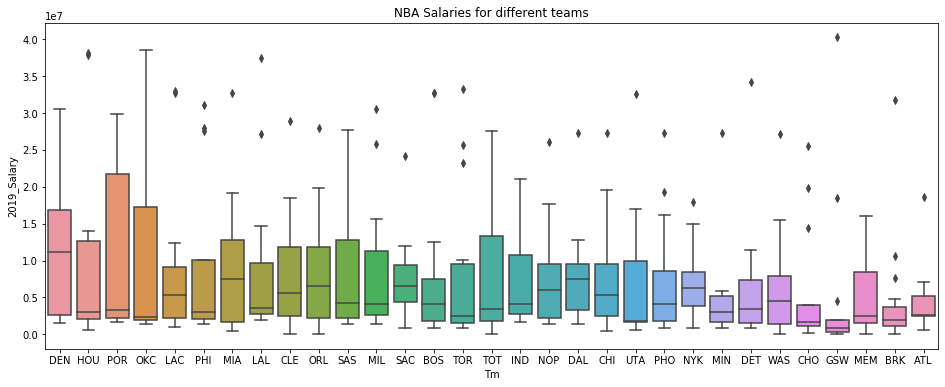

In [14]:
#box plot of salary and teams in nba (32)
var = 'Tm'
ranks = salary_trade_df.groupby("Tm")['2019_Salary'].mean().fillna(0).sort_values()[::-1].index
f, ax = plt.subplots(figsize=(16, 6))
fig = sns.boxplot(x=var, y='2019_Salary', data=salary_trade_df, order=ranks).set_title("NBA Salaries for different teams")
#fig.axis(ymin=0, ymax=800000);

# Not entirely representative of salary cap, as this does not cover the injured players who have not recorded a statistic this season

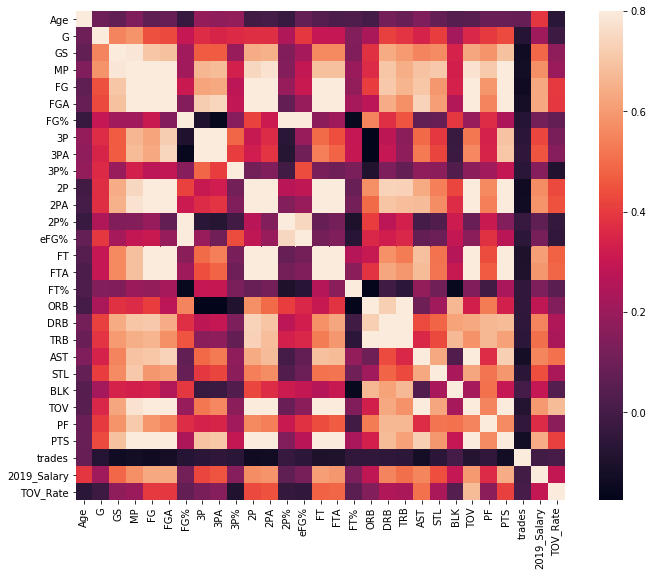

In [15]:
#correlation matrix
corr_matrix = salary_trade_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True)

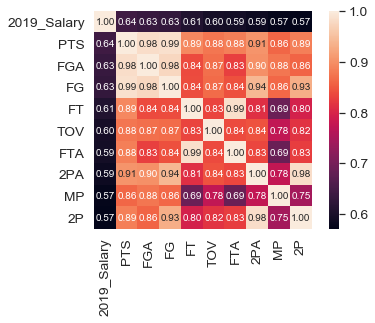

In [16]:
# top 10 correlation matrix
k = 10  #number of variables for heatmap
cols = corr_matrix.nlargest(k, '2019_Salary')['2019_Salary'].index
cm = np.corrcoef(salary_trade_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

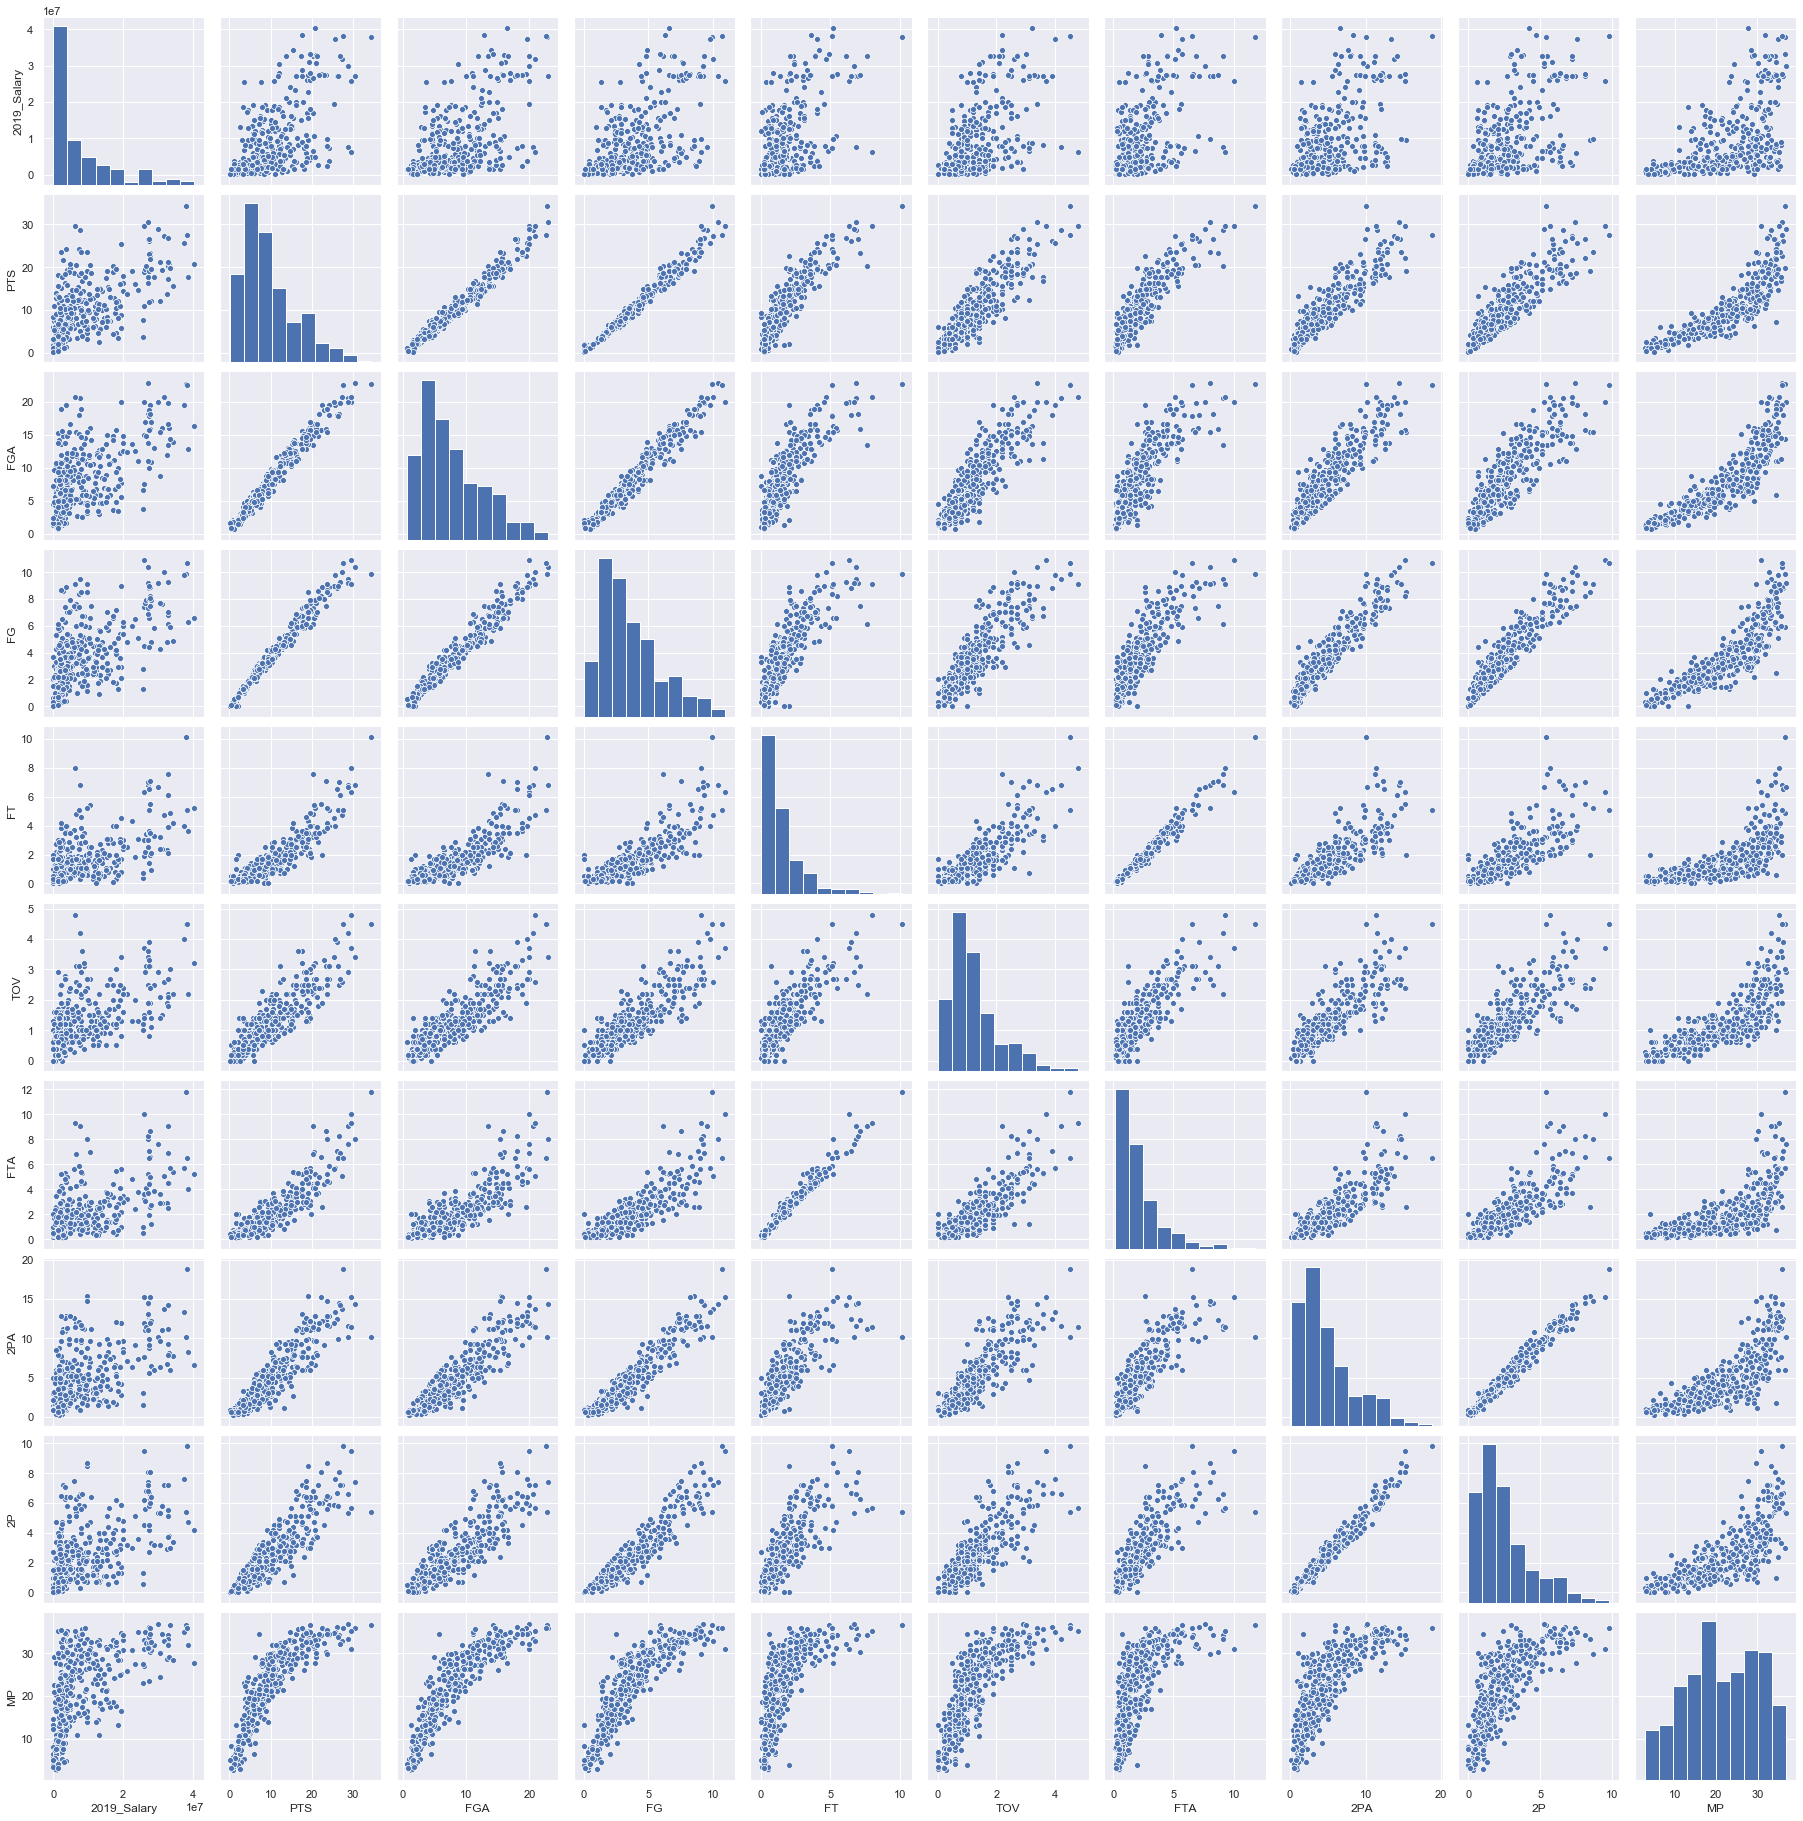

In [17]:
#scatterplot depicting the pairwise relationships between the top 10 variables
sns.set()
cols = ['2019_Salary','PTS', 'FGA', 'FG', 'FT', 'TOV', 'FTA', '2PA', '2P', 'MP']
sns.pairplot(salary_trade_df[cols], height = 2.5)

<h1>Model Exploration and Construction</h1>

<h2>Multivariate Linear Regression</h2>

In [18]:
# trying out a Linear Regression model

target_y = salary_trade_df['2019_Salary']
model_df = salary_trade_df.drop(['Pos', 'Tm', '2019_Salary'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_df, target_y)

from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(312, 28)
(312,)
(105, 28)
(105,)


In [20]:
model = linear_reg.fit(X_train, y_train)

In [21]:
predictions = model.predict(X_test)

In [22]:
#print(predictions[0:10])

In [23]:
#y_test[0:10]

In [24]:
# Review this when more time is available: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

# and this one: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

In [25]:
residual = predictions - y_test

linear_regression_diff= pd.DataFrame({'Actual (in millions)': y_test/1E6, 'Predicted (in millions)': predictions/1E6, 'Residual (in millions)': residual/1E6})
pd.set_option('display.float_format', '{:.4g}'.format)

In [26]:
# Let's see who is outplaying their salaries from the test set
linear_regression_diff.nlargest(60, 'Residual (in millions)')


Actual (in millions)  Predicted (in millions)  \
Player                                                                   
Luka Dončić                             7.683                    24.87   
Rajon Rondo                             2.565                    11.95   
JaVale McGee                                4                     13.1   
Wesley Matthews                         2.565                    10.59   
Markieff Morris                         2.242                    9.858   
Brandon Ingram                          7.265                    14.67   
Jarrett Allen                           2.377                    9.358   
Dario Šarić                             3.482                     10.4   
Dillon Brooks                           1.619                    7.964   
Thabo Sefolosha                         2.565                    8.859   
Robert Covington                         11.3                    17.42   
Brook Lopez                             12.09                    18.05   
Jabari Parker                             6.5                    12.24   
Kendrick Nunn                           1.417                    6.999   
Daniel Theis                                5                    10.48   
Juan Toscano-Anderson                  0.3502                    5.693   
Marquese Chriss                        0.7588                    6.066   
Nemanja Bjelica                         6.825                    11.68   
Danuel House                             3.54                    8.145   
James Ennis                             1.883                    6.315   
Kenrich Williams                        1.417                    5.824   
Bruce Brown                             1.417                    5.764   
Theo Pinson                             1.446                    5.419   
Jahlil Okafor                           1.702                    5.271   
Brandon Goodwin                        0.5227                    4.018   
Shaquille Harrison                     0.8983                    4.299   
Thanasis Antetokounmpo                  1.446                    4.776   
Treveon Graham                          1.679                    4.945   
Malik Newman                          0.05075                     3.29   
Jared Dudley                            2.565                    5.685   
Collin Sexton                           4.765                    7.691   
Lonzo Ball                              8.719                     11.5   
Dusty Hannahs                         0.08168                    2.759   
Bryn Forbes                             2.875                    5.538   
Paul Watson                           0.05075                    2.695   
P.J. Washington                         3.832                    6.439   
Luke Kornet                             2.195                    4.708   
Deandre Ayton                           9.563                    12.02   
Sterling Brown                          1.619                    4.034   
Josh Richardson                          10.1                    12.13   
Taj Gibson                                9.8                    11.76   
Emmanuel Mudiay                         1.737                    3.135   
Eric Gordon                             14.06                    15.38   
Deonte Burton                           1.417                     2.72   
DeAndre' Bembry                         2.604                    3.798   
Ersan İlyasova                              7                    8.184   
Eric Bledsoe                            15.62                    16.77   
Terence Davis                          0.8983                    1.839   
Mike Muscala                            2.029                    2.682   
Timothé Luwawu-Cabarrot                0.6545                    1.245   
Rondae Hollis-Jefferson                   2.5                     3.07   
Khyri Thomas                           0.8385                    1.378   
Edmond Sumner                

In [27]:
# Now let's see who is underperforming their salaries from the test set
linear_regression_diff.nsmallest(60, 'Residual (in millions)')

Actual (in millions)  Predicted (in millions)  \
Player                                                                    
Gordon Hayward                            32.7                    13.91   
Nicolas Batum                            25.57                    8.375   
Mike Conley                              32.51                    15.56   
Khris Middleton                           30.6                    14.74   
CJ McCollum                              27.56                    13.84   
DeMar DeRozan                            27.74                    15.33   
Harrison Barnes                          24.15                    11.78   
Devin Booker                             27.25                    15.57   
Kyrie Irving                             31.74                    21.44   
Al Horford                                  28                    18.79   
D'Angelo Russell                         27.29                    18.12   
Mason Plumlee                            14.04                    5.616   
Andre Iguodala                           17.19                    10.62   
Jrue Holiday                             26.13                    19.79   
Nikola Vučević                              28                    21.69   
Karl-Anthony Towns                       27.25                    20.96   
Tony Snell                               11.39                    5.135   
Marvin Williams                          15.01                    8.823   
Zhaire Smith                             3.059                     -3.1   
LaMarcus Aldridge                           26                     21.6   
Courtney Lee                             12.76                    8.805   
Nassir Little                            2.106                   -1.824   
Markelle Fultz                           9.745                    5.876   
Stanley Johnson                          3.623                  -0.1738   
Gorgui Dieng                             16.23                    12.68   
Jalen Lecque                            0.8983                   -2.472   
Danilo Gallinari                         22.62                    19.28   
Ryan Arcidiacono                             3                  -0.2872   
James Harden                              37.8                    34.56   
Mo Bamba                                 5.698                    2.604   
Jarrett Culver                           5.814                    2.744   
Georges Niang                            1.679                    -1.06   
T.J. Warren                              10.81                    8.173   
Frank Jackson                            1.619                  -0.8253   
Džanan Musa                              1.912                  -0.4585   
Delon Wright                             9.474                     7.15   
Terance Mann                                 1                   -1.244   
Malcolm Brogdon                             20                    17.95   
Semi Ojeleye                             1.619                  -0.3219   
Bojan Bogdanović                            17                    15.37   
Cameron Johnson                          4.033                    2.535   
Chris Clemons                           0.5684                  -0.7933   
T.J. Leaf                                2.813                    1.499   
Jevon Carter                             1.417                   0.1658   
Nickeil Alexander-Walker                 2.965                    1.944   
Melvin Frazier                           1.417                   0.5448   
J.J. Redick                              13.49                    12.82   
Marcus Morris                               15                    14.43   
Caleb Martin                            0.8983                   0.4818   
Dewan Hernandez                         0.8983                   0.6695   
Damian Jones                             2.305                    2.405   
Raul Neto                                1.737     

From this preliminary linear model, we can see a couple of interesting points. There is a clear delineation between players that overperform/underperform their salary, which is good. A clear indication of this is from having Chris Paul and Stephen Curry, two of the highest earning NBA players in the league. With Stephen Curry nursing a terrible wrist injury and only playing in 5 games this season, his season statistics are conflated with a low amount of games played. Nonetheless, the model is showing that, for his limited stats, he is underplaying his salary by roughly 11.9 million dollars. Chris Paul is also underperforming, stats-wise, and should be getting paid roughly 17 million dollars less than his current high salary. This is the brutal, yet objective, part of statistics based on sheer numbers, as both of these players are clearly catalysts for the success of their respective teams. So this model does not take into account the intangibles that the highest-paid players bring to the table.

In [28]:
print('Mean Absolute Error:', sklearn.metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', sklearn.metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 4637102.994304849
Mean Squared Error: 37896443861020.74
Root Mean Squared Error: 6156008.7606354775


In [29]:
# Pushed to GitHub with this folder on 5/3/2020

# Items to accomplish
# [1] Clean up this notebook, and figure out how to add markdown via visual studio [ X ]
# [2] Add commentary to guide myself and any readers that come across this [ X ]
# [3] Take down notes on how to init, add, commit, and push to repo [ X ]
# [4] Add commentary and discussion on methodology of various ML algorithms [ ]
# [5] Build a template for project building for future projects [ ]

<h1> Using the trained model on the entire training set to gain league-wide information </h1>

In [30]:
predictions_linear = model.predict(model_df)

In [37]:
salary_trade_df['Predicted_Salary'] = predictions_linear

In [ ]:
linear_comparison = salary_trade_df[['2019_Salary', 'Predicted_Salary']]/1E6
linear_residual = linear_comparison['Predicted_Salary'] - linear_comparison['2019_Salary']
linear_comparison['residual'] = linear_residual

<h2>Top 50 highest paid players for the 2019-2020 season</h2>

In [55]:
linear_comparison.sort_values(by=['2019_Salary'], ascending=False).head(50)

2019_Salary  Predicted_Salary  residual
Player                                                        
Stephen Curry                40.23             33.49    -6.737
Chris Paul                   38.51             21.87    -16.64
Russell Westbrook            38.18             26.43    -11.75
James Harden                  37.8             34.56    -3.241
LeBron James                 37.44             29.71    -7.725
Blake Griffin                34.23             22.48    -11.75
Kyle Lowry                    33.3             22.85    -10.45
Paul George                  33.01              20.1     -12.9
Kawhi Leonard                32.74             25.28    -7.466
Jimmy Butler                 32.74             25.65    -7.095
Kemba Walker                 32.74             20.52    -12.22
Gordon Hayward                32.7             13.91    -18.79
Mike Conley                  32.51             15.56    -16.96
Kyrie Irving                 31.74             21.44     -10.3
Tobias Harris                31.03             15.51    -15.52
Khris Middleton               30.6             14.74    -15.87
Paul Millsap                  30.5             16.18    -14.32
Damian Lillard                29.8             25.52    -4.283
Kevin Love                    28.9              21.7    -7.195
Nikola Vučević                  28             21.69    -6.306
Al Horford                      28             18.79    -9.211
DeMar DeRozan                27.74             15.33    -12.41
CJ McCollum                  27.56             13.84    -13.72
Joel Embiid                   27.5             26.43    -1.073
Andrew Wiggins                27.5             16.06    -11.44
Kristaps Porziņģis           27.29             22.68    -4.605
D'Angelo Russell             27.29             18.12    -9.166
Otto Porter                  27.25             8.681    -18.57
Karl-Anthony Towns           27.25             20.96    -6.295
Devin Booker                 27.25             15.57    -11.68
Anthony Davis                27.09             27.31    0.2201
Andre Drummond               27.09             21.91    -5.178
Bradley Beal                 27.09              23.5    -3.596
Hassan Whiteside             27.09             24.36     -2.73
Nikola Jokić                 26.57             20.52     -6.05
Jrue Holiday                 26.13             19.79    -6.339
LaMarcus Aldridge               26              21.6    -4.399
Steven Adams                 25.84             13.86    -11.98
Giannis Antetokounmpo        25.84             25.77  -0.07542
Marc Gasol                    25.6             14.84    -10.75
Nicolas Batum                25.57             8.375    -17.19
Harrison Barnes              24.15             11.78    -12.37
Serge Ibaka                  23.27             12.95    -10.32
Danilo Gallinari             22.62             19.28    -3.333
Victor Oladipo                  21             13.46    -7.544
Malcolm Brogdon                 20             17.95    -2.051
Terry Rozier                 19.89             11.29    -8.607
Aaron Gordon                 19.86             14.06    -5.805
Zach LaVine                   19.5             17.88    -1.619
Kent Bazemore                19.27             10.85    -8.418

<h2>Top 50 highest predicted salaries based on their season performance</h2>

In [49]:
linear_comparison.sort_values(by=['Predicted_Salary'], ascending=False).head(50)

2019_Salary  Predicted_Salary  residual
Player                                                        
James Harden                  37.8             34.56    -3.241
Stephen Curry                40.23             33.49    -6.737
LeBron James                 37.44             29.71    -7.725
Anthony Davis                27.09             27.31    0.2201
Joel Embiid                   27.5             26.43    -1.073
Russell Westbrook            38.18             26.43    -11.75
Giannis Antetokounmpo        25.84             25.77  -0.07542
Jimmy Butler                 32.74             25.65    -7.095
Damian Lillard                29.8             25.52    -4.283
Kawhi Leonard                32.74             25.28    -7.466
Luka Dončić                  7.683             24.87     17.19
Hassan Whiteside             27.09             24.36     -2.73
Trae Young                   6.273             23.82     17.55
Bradley Beal                 27.09              23.5    -3.596
Kyle Lowry                    33.3             22.85    -10.45
Kristaps Porziņģis           27.29             22.68    -4.605
Blake Griffin                34.23             22.48    -11.75
Andre Drummond               27.09             21.91    -5.178
Chris Paul                   38.51             21.87    -16.64
Kevin Love                    28.9              21.7    -7.195
Nikola Vučević                  28             21.69    -6.306
LaMarcus Aldridge               26              21.6    -4.399
Kyrie Irving                 31.74             21.44     -10.3
Karl-Anthony Towns           27.25             20.96    -6.295
Nikola Jokić                 26.57             20.52     -6.05
Kemba Walker                 32.74             20.52    -12.22
Paul George                  33.01              20.1     -12.9
Jrue Holiday                 26.13             19.79    -6.339
Danilo Gallinari             22.62             19.28    -3.333
Pascal Siakam                2.352             19.25      16.9
Al Horford                      28             18.79    -9.211
Ricky Rubio                  16.19             18.32     2.134
D'Angelo Russell             27.29             18.12    -9.166
Brook Lopez                  12.09             18.05     5.957
Malcolm Brogdon                 20             17.95    -2.051
Zach LaVine                   19.5             17.88    -1.619
Robert Covington              11.3             17.42     6.117
Carmelo Anthony              2.159             17.04     14.88
Will Barton                  12.96             16.79     3.829
Eric Bledsoe                 15.62             16.77     1.145
Domantas Sabonis              3.53             16.55     13.03
Julius Randle                   18             16.33     -1.67
Lou Williams                     8             16.33     8.329
Draymond Green               18.54             16.29    -2.253
Spencer Dinwiddie             10.6              16.2     5.604
Paul Millsap                  30.5             16.18    -14.32
Andrew Wiggins                27.5             16.06    -11.44
Jonas Valančiūnas               16              15.7   -0.2976
Devin Booker                 27.25             15.57    -11.68
Mike Conley                  32.51             15.56    -16.96

<h2>Top 10 players playing beyond expectations of their salary (in millions)</h2>

In [57]:
linear_comparison.sort_values(by=['residual'], ascending=False).head(10)

2019_Salary  Predicted_Salary  residual
Player                                                   
Trae Young              6.273             23.82     17.55
Luka Dončić             7.683             24.87     17.19
Pascal Siakam           2.352             19.25      16.9
Carmelo Anthony         2.159             17.04     14.88
Devonte' Graham         1.417                15     13.58
Domantas Sabonis         3.53             16.55     13.03
Alec Burks               2.32             14.52      12.2
Shabazz Napier          1.883             13.95     12.07
Donovan Mitchell        3.636             15.03     11.39
Vince Carter            2.565             13.93     11.36

<h2>Top 10 most overpaid players (in millions)</h2>

In [58]:
linear_comparison.sort_values(by=['residual'], ascending=True).head(10)

2019_Salary  Predicted_Salary  residual
Player                                                  
Gordon Hayward          32.7             13.91    -18.79
Otto Porter            27.25             8.681    -18.57
Nicolas Batum          25.57             8.375    -17.19
Mike Conley            32.51             15.56    -16.96
Chris Paul             38.51             21.87    -16.64
Khris Middleton         30.6             14.74    -15.87
Tobias Harris          31.03             15.51    -15.52
Paul Millsap            30.5             16.18    -14.32
CJ McCollum            27.56             13.84    -13.72
Tyler Johnson          19.25             5.915    -13.33

Lots of analysis done! Will turn my attention to other models